In [1]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set(color_codes=True) # Set style and color of graphs

import pandas as pd
f1 = pd.read_csv("/Users/houzhuo/Downloads/data/02_01/02_01.csv")
f2 = pd.read_csv("/Users/houzhuo/Downloads/data/02_02/02_02.csv")
f3 = pd.read_csv("/Users/houzhuo/Downloads/data/05_01/05_01.csv")
f4 = pd.read_csv("/Users/houzhuo/Downloads/data/06_01/06_01.csv")
f5 = pd.read_csv("/Users/houzhuo/Downloads/data/07_01/07_01.csv")
f6 = pd.read_csv("/Users/houzhuo/Downloads/data/07_02/07_02.csv")
f7 = pd.read_csv("/Users/houzhuo/Downloads/data/07_03/07_03.csv")
f8 = pd.read_csv("/Users/houzhuo/Downloads/data/07_04/07_04.csv")
cap = pd.concat([f1,f2,f3,f4,f5,f6,f7,f8],axis=0)
t1 = pd.read_csv("/Users/houzhuo/Downloads/data/02_01/test3.csv")
t2 = pd.read_csv("/Users/houzhuo/Downloads/data/02_02/test3.csv")
t3 = pd.read_csv("/Users/houzhuo/Downloads/data/05_01/test3.csv")
t4 = pd.read_csv("/Users/houzhuo/Downloads/data/06_01/test3.csv")
t5 = pd.read_csv("/Users/houzhuo/Downloads/data/07_01/test3.csv")
t6 = pd.read_csv("/Users/houzhuo/Downloads/data/07_02/test3.csv")
t7 = pd.read_csv("/Users/houzhuo/Downloads/data/07_03/test3.csv")
t8 = pd.read_csv("/Users/houzhuo/Downloads/data/07_04/test3.csv")
rob = pd.concat([t1,t2,t3,t4,t5,t6,t7,t8],axis=0)
full = pd.concat([cap,rob],axis=1)
print(full.shape,cap.shape,rob.shape)
full.head()

(1521, 44) (1521, 18) (1521, 26)


,1,2,3,4,5,6,7,8,9,10,...,Shoulder_L,Hip_R,Shoulder_R,Hip_u_L,Head,Hip_u_R,Head_u,Shoulder_pitch_L,Head_pitch,Shoulder_pitch_R
0,32.170,31.226,54.610,-12.289,37.270,-19.412,-15.922,-2.2978,-0.32138,-9.8953,...,-2196.000000,0,2243.000000,0,0,0,0,-254.000000,0,-631.000000
1,33.935,34.161,56.665,-12.488,39.463,-19.987,-17.261,-2.5077,-0.40396,-10.5590,...,-2196.736842,0,2240.684211,0,0,0,0,-240.421053,0,-597.947368
2,32.961,31.564,54.746,-11.809,36.489,-19.046,-16.506,-2.3873,-0.34868,-10.0670,...,-2197.473684,0,2238.368421,0,0,0,0,-226.842105,0,-564.894737
3,32.990,30.708,55.468,-11.346,35.372,-18.598,-16.070,-2.3202,-0.32733,-10.2220,...,-2198.210526,0,2236.052632,0,0,0,0,-213.263158,0,-531.842105
4,33.070,29.764,57.020,-10.839,34.338,-18.141,-15.418,-2.2212,-0.30061,-10.4740,...,-2198.947368,0,2233.736842,0,0,0,0,-199.684211,0,-498.789474


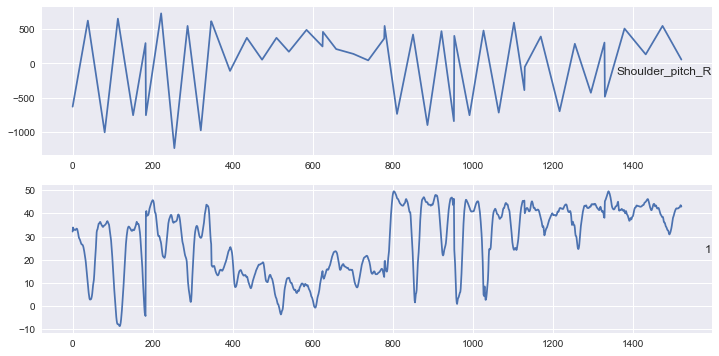

In [3]:
dataset = pd.concat([full['Shoulder_pitch_R'],full['1']] , axis=1 )
dataset.head()
type(dataset)
import matplotlib.pyplot as plt
values = dataset.values
# specify columns to plot
groups = [0, 1]
i=1
plt.figure(figsize=(12,6))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

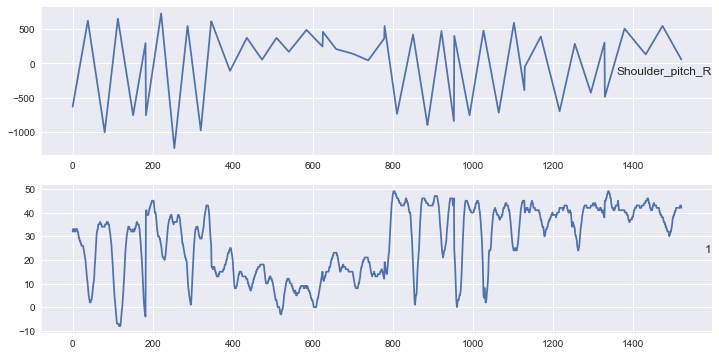

In [4]:
from sklearn import preprocessing
values = dataset.values
#values = dataset.astype(np.float32)
n_features=3
for i in range(2):
    for j in range(len(values[:,i])):
        values[:,i][j] =int(values[:,i][j]) 
    
# specify columns to plot
groups = [0, 1]
i=1
plt.figure(figsize=(12,6))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()



In [5]:
reframed = series_to_supervised(values, 1, 1)

In [6]:
reframed = reframed.values
y=reframed[:,0]
target_y = reframed[:,-2]

In [7]:
target_y

array([-597., -564., -531., ...,   77.,   67.,   56.])

In [8]:
train = values[:1000,:]
test = values[1000:1500,:]

train_X_pre = train[:,1]
train_y_pre = y[:1000]
target_y_pre = target_y[:1000]
test_X_pre = test[:,1]
test_y = test[:,0]

In [9]:
train_X=[]
train_y=[]
target_y=[]
test_X=[]
for i in range(100):
    train_X.append(train_X_pre[i*10:(i+1)*10])
    train_y.append(train_y_pre[i*10:(i+1)*10])
    target_y.append(target_y_pre[i*10:(i+1)*10])
for i in range(50):
    test_X.append(test_X_pre[i*10:(i+1)*10])

In [11]:
test_X

[array([40., 40., 41., 41., 42., 42., 43., 44., 44., 44.]),
 array([45., 45., 45., 44., 44., 42., 41., 40., 38., 36.]),
 array([33., 31., 28., 24., 19., 11.,  5.,  4.,  8.,  8.]),
 array([ 5.,  2.,  2.,  3.,  5.,  7.,  9., 11., 15., 21.]),
 array([24., 24., 24., 24., 25., 27., 31., 33., 35., 37.]),
 array([39., 40., 41., 41., 41., 42., 41., 41., 40., 40.]),
 array([39., 39., 39., 39., 38., 38., 37., 37., 38., 38.]),
 array([38., 38., 39., 39., 40., 41., 42., 42., 42., 43.]),
 array([43., 44., 44., 44., 43., 43., 43., 43., 42., 41.]),
 array([41., 40., 38., 37., 35., 33., 31., 29., 27., 26.]),
 array([25., 24., 24., 24., 24., 25., 25., 24., 24., 24.]),
 array([25., 26., 27., 29., 31., 33., 35., 37., 39., 41.]),
 array([42., 43., 44., 44., 45., 45., 45., 45., 45., 40.]),
 array([40., 41., 41., 42., 42., 42., 42., 41., 41., 41.]),
 array([40., 40., 41., 42., 43., 44., 44., 45., 44., 44.]),
 array([43., 42., 42., 42., 42., 41., 41., 41., 41., 41.]),
 array([41., 41., 41., 41., 41., 40., 40

In [12]:
X1=list()
# encode
for i, X in enumerate(train_X):
    src_encoded = to_categorical([X], num_classes=1521)
# store
    X1.append(src_encoded)
X1 = np.array(X1)
X1 = X1.reshape(100,10,1521)
X2=list()
# encode
for i, X in enumerate(train_y):
    tar_encoded = to_categorical([X], num_classes=1521)
# store
    X2.append(tar_encoded)
X2 = np.array(X2)
X2 = X2.reshape(100,10,1521)
y=list()
# encode
for i, X in enumerate(target_y):
    tar_decoded = to_categorical([X], num_classes=1521)
# store
    y.append(tar_decoded)
y = np.array(y)
y = y.reshape(100,10,1521)

test_X1=list()
for i, X in enumerate(test_X):
    test_encoded = to_categorical([X], num_classes=1521)
# store
    test_X1.append(tar_decoded)
test_X1 = np.array(test_X1)
test_X1 = test_X1.reshape(50,10,1521)

In [13]:
X1.shape

(100, 10, 1521)

In [14]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
#n_input=10 #每条输入的长度
#n_output=10 #decoder输入的长度
#n_units=1521
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model
 

In [48]:
type(test_X_pre[1])

numpy.float64

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 2s 25ms/step - loss: 7.3265 - acc: 0.0000e+00 - val_loss: 7.3279 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 1s 12ms/step - loss: 7.3081 - acc: 0.0100 - val_loss: 7.3291 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 1s 12ms/step - loss: 7.2593 - acc: 0.0087 - val_loss: 7.3403 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 1s 12ms/step - loss: 6.9293 - acc: 0.0037 - val_loss: 7.6236 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 1s 12ms/step - loss: 6.5280 - acc: 0.0050 - val_loss: 8.2324 - val_acc: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 1s 12ms/step - loss: 6.3649 - acc: 0.0075 - val_loss: 8.6857 - val_acc: 0.0000e+00
Epoch 7/100
80/80 [==============================] - 1s 12ms/step - loss: 6.3098 - acc: 0.0062 - val_loss: 8.8736 - val_acc: 0.0000e+00


80/80 [==============================] - 1s 12ms/step - loss: 5.9009 - acc: 0.0150 - val_loss: 10.6476 - val_acc: 0.0000e+00
Epoch 61/100
80/80 [==============================] - 1s 11ms/step - loss: 5.8934 - acc: 0.0125 - val_loss: 10.6456 - val_acc: 0.0000e+00
Epoch 62/100
80/80 [==============================] - 1s 11ms/step - loss: 5.8861 - acc: 0.0162 - val_loss: 10.6475 - val_acc: 0.0000e+00
Epoch 63/100
80/80 [==============================] - 1s 12ms/step - loss: 5.8786 - acc: 0.0100 - val_loss: 10.6631 - val_acc: 0.0000e+00
Epoch 64/100
80/80 [==============================] - 1s 11ms/step - loss: 5.8710 - acc: 0.0137 - val_loss: 10.6508 - val_acc: 0.0000e+00
Epoch 65/100
80/80 [==============================] - 1s 12ms/step - loss: 5.8629 - acc: 0.0162 - val_loss: 10.5730 - val_acc: 0.0000e+00
Epoch 66/100
80/80 [==============================] - ETA: 0s - loss: 5.8507 - acc: 0.017 - 1s 11ms/step - loss: 5.8542 - acc: 0.0175 - val_loss: 10.6159 - val_acc: 0.0000e+00
Epoch 67/

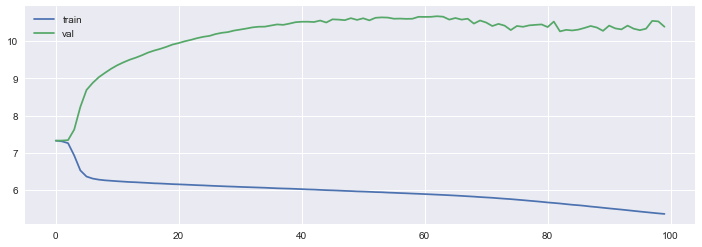

In [15]:
# configure problem
n_features = 1521
n_steps_in = 10
n_steps_out = 10
# define model
train, infenc, infdec = define_models(n_features, n_features, 32)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# generate training dataset
#print(X1.shape,X2.shape,y.shape)
# train model
history = train.fit([X1, X2], y,#fit的时候采用的是前面的时序序列
          batch_size=5,
          epochs=100,
          validation_split=0.2)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [31]:
test_X1.shape

(50, 10, 1521)

In [38]:
# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, int(test_y[0])] = 1.
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return array(output)
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [37]:
test_y[0]

-438.0

In [39]:
output=[]
for seq_index in range(50):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_X1[seq_index:seq_index + 1,:,:]
    #print(input_seq)
    #print('Input sentence:', input_texts[seq_index])
    #print('Decoded sentence:', decoded_sentence)
    target = predict_sequence(infenc, infdec, input_seq, n_steps_out, n_features)    
    output.append(one_hot_decode(target))
output

[[339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236, 236],
 [339, 339, 417, 432, 197, 197, 453, 294, 236,